In [1]:
!pip install gif
isplot = 0
check = 0

## Excercise 1 - One vs One classifier

The aim of the excercise is to build a multiclass classifier using a binary classifier using a one-vs-one classifier. Similar to the tutorial, you are provided with a 3 class synthetic dataset. In a one-vs-one classifier, a binary classifier is learnt between every pair of class. You are required to write the code and visualize the decision boundaries for the one-vs-one classifier setting.

## Import util.ipynb for helper functions

In [2]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        #print('searching: %s'%nb_path)
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        #print('searching: %s' % nb_path)
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        #print('Found %d cells'%len(nb.cells))
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]


#  register the NotebookFinder with sys.meta_path
print('running importer')
sys.meta_path.append(NotebookFinder())

running importer


## Imports

In [3]:
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set();
import pandas as pd
from utils import plot_decision_boundary, get_accuracy, get_prediction
from utils import plot_2D_input_datapoints, generate_gifs, sigmoid, normalize
import math
import gif
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from utils.ipynb


## Constructing dataset

In [4]:
fig = plt.figure(figsize=(8,8));

np.random.seed(4)

# Getting only linearly separable dataset
separable = False
while not separable:
    samples = make_classification(n_samples=450, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=3)
    red = samples[0][samples[1] == 0]
    blue = samples[0][samples[1] == 1]
    green = samples[0][samples[1] == 2]
    separable = any([red[:, k].max() < blue[:, k].min() or red[:, k].min() > blue[:, k].max() 
                  or green[:, k].min() > blue[:, k].max() or green[:, k].min() > red[:, k].max() 
                  or blue[:, k].min() > green[:, k].max() or red[:, k].min() > green[:, k].max() for k in range(2)])

X, y = samples

y = y.reshape((-1, 1))

# Absorbing weight b of the hyperplane
b_ones = np.ones((len(X), 1))
X = np.hstack((X, b_ones))

<Figure size 576x576 with 0 Axes>

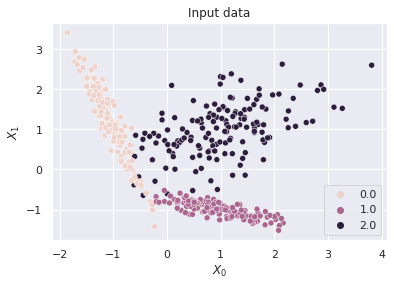

In [5]:
plot_2D_input_datapoints(X[:, :2], y)

## Train-Val-Test split

In [6]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, y, shuffle=True, test_size = 0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = 0.125)

print("Training dataset: ", X_train.shape)
print("Validation dataset: ", X_val.shape)
print("Test dataset: ", X_test.shape)

Training dataset:  (315, 3)
Validation dataset:  (45, 3)
Test dataset:  (90, 3)


## Dataset plotted

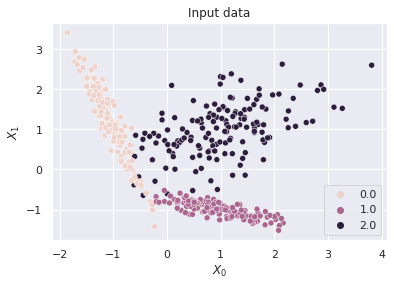

# Write your code below

## Weight Initialization

initialize weights using uniform distribution and store it in initial_weights.


In [7]:
def weight_init_uniform_dist(X, y):
    np.random.seed(312)
    n_samples, n_features = np.shape(X)
    _, n_outputs = np.shape(y)

    limit = 1 / math.sqrt(n_features)
    weights = np.random.uniform(-limit, limit, (n_features, n_outputs))
    weights[-1] = 0

    return weights

In [8]:
initial_weights = weight_init_uniform_dist(X_train, Y_train)

## Train a model for binary classification

Uses batch gradient descent

In [9]:
def predict(x, w):
  wtx = np.dot(x, w)
  y = sigmoid(wtx)
  return y

In [10]:
def train_binary_classification(X_train, Y_train, base_weights, num_epochs, learning_rate):
    weights = base_weights
    n_samples = X_train.shape[0]
    for epoch in range(1, num_epochs+1):
        # Computing weighted inputs and predicting output
        y_pred = predict(X_train, weights)
        # Calculating gradient and updating weights
        gradient = 1 * np.dot(X_train.T, (Y_train - y_pred))
        weights += (learning_rate/n_samples) * gradient
        # weights = np.round(weights, decimals=7) # why tho?
        epoch += 1
    return weights

In [11]:
def accuracy_binary_classification(x, y, w):
  y_pred = np.array(predict(x, w) >= 0.5)
  y_actual = y
  return np.mean(y_actual == y_pred)

In [12]:
def plot_boundary_binary_classification(x, y, w):
  plot_2D_input_datapoints(x[:, :2], y)
  plt.xlabel("$X_0$") 
  plt.ylabel("$X_1$")
  
  j = np.array([x[:, 0].min(), x[:, 0].max()])
  k = -(j * w[0] + w[2]) / w[1]
  plt.plot(j, k, color='k', linestyle="--")

  plt.show()

## Splitting the dataset according to two classes then relabelling them

- 0 => it is first class
- 1 => it is second class

In [13]:
def make_pairwise_data(x, y, k1, k2):  # k1 and k2 are the two classes
  # Identify those y_train indices correcsponding to the given classes
  binary_y_indices = np.argwhere((y == k1, y == k2)).T[1]
  binary_x = x[binary_y_indices]
  binary_y = y[binary_y_indices]
  # one-vs-one binary classifier: assign k1 as 0 and k2 as 1
  binary_y = np.where(binary_y == k1, 0, 1)
  # print(binary_x.shape,binary_y.shape, binary_y_indices.shape)
  return binary_x, binary_y

## ONE-VS-ONE CLASSIFIER

### Training

In [14]:
def train_one_vs_one(X_train, Y_train, base_weights, num_epochs, learning_rate):
    final_weights = base_weights
    classes = np.unique(Y_train) # contains all classes present
    mi = 0  # model number
    # Training using Batch GD
    for k1_ind in range(len(classes)):
        for k2_ind in range(k1_ind):
            k1 = classes[k1_ind]
            k2 = classes[k2_ind]
            # make the training data
            binary_x, binary_y = make_pairwise_data(X_train, Y_train, k1, k2)
            # train
            trained_weight = train_binary_classification(binary_x, binary_y, base_weights[mi], num_epochs, learning_rate)
            # Display details, with graph
            acc = accuracy_binary_classification(binary_x, binary_y, trained_weight)
            print("One-vs-one classifier for classes: ", k1, "vs", k2, ":", acc)
            # Plot for fun
            if(isplot):
                plot_boundary_binary_classification(binary_x, binary_y, trained_weight)
            # Add to list
            final_weights[mi] = trained_weight.copy()
            mi += 1
    print("Training complete")
    return final_weights

### Predict a set of points in a one-vs-one setting

In [15]:
def predict_one_vs_one(x, y, ws):
    # Each model (0,1,2) corresponds to the classifications (1,0),(2,0),(2,1)
    mi = 0  # model number
    classes=[0,1,2]
    #classes = np.unique(y)  # get all classes
    # point as per the model says
    points = np.zeros((len(classes), (x.shape)[0]))
    for k1_ind in range(len(classes)):
        for k2_ind in range(k1_ind):
            k1 = classes[k1_ind]
            k2 = classes[k2_ind]
            # print(ws.shape)
            w = ws[mi]
            y_pred = predict(x, w).flatten()
            #print(y_pred.shape, points[k1_ind].shape)
            y_pred_k1 = np.array(1-y_pred)
            y_pred_k2 = np.array(y_pred)
            # update scores
            points[k1_ind] += y_pred_k1
            points[k2_ind] += y_pred_k2
            mi += 1
    # for each point find the majority voted class
    final_y_pred = np.argmax(points, axis=0)
    if(check):
        print(points.shape, final_y_pred.shape)
        for p in range(len(points[0])):
            if(y[p] != final_y_pred[p]):
                print(points[:, p], final_y_pred[p], y[p])
    return final_y_pred

### Compute Accuracy of one-vs-one model

In [16]:
def accuracy_one_vs_one(x, y, ws):
    y_pred = predict_one_vs_one(x, y, ws).flatten()
    y_actual = y.flatten()
    if(check):
        print(y_pred, y_actual)
    return np.mean(y_actual == y_pred)

### Compute class wise accuracy of the model

In [17]:
def class_wise_accuracy(x, y, ws):
    acc = np.zeros(3)
    for i in [0, 1, 2]:
        if(check):
            print("Class", i)
        y_in = np.argwhere(y == i).T[1]
        xx = x[y_in]
        yy = y[y_in]
        # print(yy.shape)
        acc[i] = accuracy_one_vs_one(xx, yy, ws)
    return acc

## Calling all the functions

In [18]:
base_weights = np.array([initial_weights]*3)
print("Starting weights:\n", base_weights)

Starting weights:
 [[[-0.32709562]
  [-0.09385173]
  [ 0.        ]]

 [[-0.32709562]
  [-0.09385173]
  [ 0.        ]]

 [[-0.32709562]
  [-0.09385173]
  [ 0.        ]]]


In [19]:
trained_weights = train_one_vs_one(X_train, Y_train, base_weights, num_epochs=100000, learning_rate=1)

One-vs-one classifier for classes:  1 vs 0 : 1.0
One-vs-one classifier for classes:  2 vs 0 : 0.985781990521327
One-vs-one classifier for classes:  2 vs 1 : 0.9859154929577465
Training complete


In [20]:
print(trained_weights)

[[[-38.34476516]
  [ -8.0171148 ]
  [-15.5705567 ]]

 [[-14.88104109]
  [ -3.0828594 ]
  [ -6.6214763 ]]

 [[  1.48943551]
  [-21.85513608]
  [-13.00927201]]]


In [21]:
print("Training set:\tAccuracy: ", accuracy_one_vs_one(X_train, Y_train, trained_weights),
      "\tClasswise accuracy", class_wise_accuracy(X_train, Y_train, trained_weights))
print("Validation set:\tAccuracy: ", accuracy_one_vs_one(X_val, Y_val, trained_weights),
      "\tClasswise accuracy", class_wise_accuracy(X_val, Y_val, trained_weights))
print("Test set:\tAccuracy: ", accuracy_one_vs_one(X_test, Y_test, trained_weights),
      "\tClasswise accuracy", class_wise_accuracy(X_test, Y_test, trained_weights))

Training set:	Accuracy:  0.9841269841269841 	Classwise accuracy [1. 1. 1.]
Validation set:	Accuracy:  0.9777777777777777 	Classwise accuracy [1. 1. 1.]
Test set:	Accuracy:  0.9888888888888889 	Classwise accuracy [1. 1. 1.]


## Drawing a decision boundary

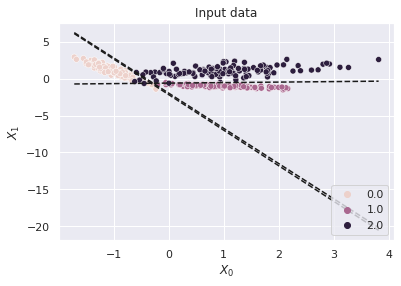

In [22]:
plot_2D_input_datapoints(X_train[:, :2], Y_train)
plt.xlabel("$X_0$")
plt.ylabel("$X_1$")

for weight in [trained_weights[0], trained_weights[1], trained_weights[2]]:
    j = np.array([X_train[:, 0].min(), X_train[:, 0].max()])
    k = -(j * weight[0] + weight[2]) / weight[1]
    plt.plot(j, k, color='k', linestyle="--")

In [23]:
xlist = np.linspace(-2.0, 4.0, 100)
ylist = np.linspace(-2.0, 4.0, 100)
X, Y = np.meshgrid(xlist, ylist)

a = []
for x in xlist:
    for y in ylist:
        a += [[x, y, 1]]
a = np.array(a)
Z = np.array(predict_one_vs_one(x=np.array(a), y=Y_test, ws=trained_weights))
Z = Z.reshape((100, 100))
plt.figure()

contour = plt.contour(X, Y, Z, hue="y")
contour_filled = plt.contourf(X, Y, Z, alpha=0.25, hue="y")

plot_2D_input_datapoints(X_train[:, :2], Y_train)  # training set is plotted
# plot_2D_input_datapoints(X_test[:, :2], Y_test)  # test set is plotted
# plot_2D_input_datapoints(X_val[:, :2], Y_val)  # validation set is plotted

plt.title('Filled Contours Plot')
plt.show()